# Clean Text Data

In [11]:
# # Check module locations if required
# import sys
# import pprint
# pprint.pprint(sys.path)

In [12]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [13]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

## Define Utility Functions

In [14]:
# Functions for map() or apply()

def get_word_count(x):
    '''
    Retun the number of words for the given text x.
    '''
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))
        
def get_rate_change(x):
    '''
    Returns rate change decision of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
    
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['RateDecision']
    else:        
        return None

def get_rate(x):
    '''
    Returns rate of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
        
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['Rate']
    else:        
        return None

def get_next_meeting_date(x):
    '''
    Returns the next fomc meeting date for the given date x, referring to fomc_calendar DataFrame.
    Usually FOMC Meetings takes two days, so it starts searching from x+2.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None

    # Add two days to get the day after next
    x = x + dt.timedelta(days=2)
    
    # Just in case, sort fomc_calendar from older to newer
    fomc_calendar.sort_index(ascending=True, inplace=True)
    
    if fomc_calendar.index[0] > x:
        # If the date is older than the first FOMC Meeting, do not return any date.
        return None
    else:
        for i in range(len(fomc_calendar)):
            if x < fomc_calendar.index[i]:
                return fomc_calendar.index[i]
        # If x is greater than the newest FOMC meeting date, do not return any date.
        return None
    
def get_chairperson(x):
    '''
    Return a tuple of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

In [15]:
def reorganize_df(df, doc_type):
    '''
    Reorganize the loaded dataframe, which has been obrained by FomcGetData for further processing
        - Add type
        - Add word count
        - Add rate, decision (for meeting documents, None for the others)
        - Add next meeting date, rate and decision
        - Copy contents to org_text
        - Remove line breaks from contents in text
        - Split contents by "[SECTION]" to list in text_sections
    '''
    
    if doc_type in ('statement', 'minutes', 'presconf_script', 'meeting_script'):
        is_meeting_doc = True
    elif doc_type in ('speech', 'testimony'):
        is_meeting_doc = False
    else:
        print("Invalid doc_type [{}] is given!".format(doc_type))
        return None
    
    dict = {
        'type': doc_type,
        'date': df['date'],
        'title': df['title'],
        'speaker': df['speaker'],
        'word_count': df['contents'].map(get_word_count),
        'decision': df['date'].map(lambda x: get_rate_change(x) if is_meeting_doc else None),
        'rate': df['date'].map(lambda x: get_rate(x) if is_meeting_doc else None),
        'next_meeting': df['date'].map(get_next_meeting_date),
        'next_decision': df['date'].map(get_next_meeting_date).map(get_rate_change),
        'next_rate': df['date'].map(get_next_meeting_date).map(get_rate),        
        'text': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip()),
        'text_sections': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
        'org_text': df['contents']
    }

    new_df = pd.DataFrame(dict)
    new_df['decision'] = new_df['decision'].astype('Int8')
    new_df['next_decision'] = new_df['next_decision'].astype('Int8')
    print("No rate decision found: ", new_df['decision'].isnull().sum())
    print("Shape of the dataframe: ", new_df.shape)
    #new_df.dropna(subset=['decision'], axis=0, inplace=True)
    return new_df

In [16]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    split_df['decision'] = split_df['decision'].astype('Int8')
    split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

In [17]:
def remove_short_section(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    It concatinate sections with a space, which exceeds min_words and update 'text'.
    As a fallback, keep a text which concatinates sections having more than 20 words and use it
     if there is no section having more than min_words.
    If there is no sections having more than 20 words, remove the row.
    '''
    new_df = df.copy()
    new_text_list = []
    new_text_section_list = []
    new_wc_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text = ""
        bk_text = ""
        new_text_section = []
        bk_text_section = []
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text += " " + section
                new_text_section.append(section)
            elif num_words > 20:
                bk_text += " " + section
                bk_text_section.append(section)
                
        
        new_text = new_text.strip()
        bk_text = bk_text.strip()
        
        if len(new_text) > 0:
            new_text_list.append(new_text)
            new_text_section_list.append(new_text_section)
        elif len(bk_text) > 0:
            new_text_list.append(bk_text)
            new_text_section_list.append(bk_text_section)
        else:
            new_text_list.append("")
            new_text_section_list.append("")
        
        # Update the word count
        new_wc_list.append(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', new_text_list[-1])))
        
    new_df['text'] = new_text_list
    new_df['word_count'] = new_wc_list
    
    return new_df.loc[new_df['word_count'] > 0]

def remove_short_nokeyword(df, keywords = ['rate', 'rates', 'federal fund', 'outlook', 'forecast', 'employ', 'economy'], min_times=2, min_words=50):
    '''
    Drop sections which do not have any one of keywords for min_times times
     before applying remove_short_section()
    '''
    
    new_df = df.copy()
    new_section_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_section = []
                
        for section in row['text_sections']:
            if len(set(section.split()).intersection(keywords)) >= min_times:
                new_section.append(section)
        
        new_section_list.append(new_section)
    
    new_df['text_sections'] = new_section_list
    
    return remove_short_section(new_df, min_words=min_words)

## Load Data

### Chairpersons

In [18]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

,Surname,FirstName,FromDate,ToDate
0,Volcker,Paul,1979-08-06,1987-08-10
1,Greenspan,Alan,1987-08-11,2006-01-31
2,Bernanke,Ben,2006-02-01,2014-01-31
3,Yellen,Janet,2014-02-03,2018-02-03
4,Powell,Jerome,2018-02-05,2022-02-05


### Load Calendar

In [19]:
file = open('../data/preprocessed/fomc_calendar.pickle', 'rb')

fomc_calendar = pickle.load(file)
file.close()

print(fomc_calendar.shape)
fomc_calendar

(403, 8)


,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision,RateChanged
date,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.5,-0.5,-1,1
1982-11-16,False,False,False,Paul Volcker,9.0,-0.5,-1,1
1982-12-21,False,False,False,Paul Volcker,8.5,0.0,0,0
1983-01-14,False,False,True,Paul Volcker,8.5,0.0,0,0
1983-01-21,False,False,True,Paul Volcker,8.5,0.0,0,0
...,...,...,...,...,...,...,...,...
2020-06-10,False,True,False,Jerome Powell,0.0,0.0,0,0
2020-07-29,False,False,False,Jerome Powell,0.0,0.0,0,0
2020-08-27,False,False,False,Jerome Powell,0.0,0.0,0,0


In [20]:
# #Check caleander
# fomc_calendar.loc[fomc_calendar.index >= dt.datetime(1998, 1, 27)]

### Statement

In [21]:
file = open('../data/FOMC/statement.pickle', 'rb')

statement_df = pickle.load(file)
file.close()

print(statement_df.shape)
statement_df

(201, 4)


,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement
...,...,...,...,...
196,2020-06-10,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Statement
197,2020-07-29,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Statement
198,2020-08-27,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Statement
199,2020-09-16,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Statement


In [22]:
# Sample Contents - the 2nd last
print(statement_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Minutes

In [23]:
file = open('../data/FOMC/minutes.pickle', 'rb')

minutes_df = pickle.load(file)
file.close()

print(minutes_df.shape)
minutes_df

(229, 4)


,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
...,...,...,...,...
224,2020-03-15,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Meeting Minutes
225,2020-04-29,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Meeting Minutes
226,2020-06-10,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Meeting Minutes
227,2020-07-29,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Meeting Minutes


In [24]:
# Sample Contents - the 2nd last
print(minutes_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Transcripts

In [25]:
file = open('../data/FOMC/meeting_script.pickle', 'rb')

meeting_script_df = pickle.load(file)
file.close()

print(meeting_script_df.shape)
meeting_script_df

(200, 4)


,date,contents,speaker,title
0,1990-02-07,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...,Alan Greenspan,FOMC Meeting Transcript
1,1990-03-27,CHAIRMAN GREENSPAN. Governor LaWare has moved that it is agood morning. Are there any seconds?\n\n[SECTION]\n\nMR. JOHNSON. Second.\n\n[SECTION]\n\nSPEAKER(?). It's too early to ...,Alan Greenspan,FOMC Meeting Transcript
2,1990-05-15,CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move them.\n\n[SECTION]\n\nMR. KELLEY. Second.\n\n[SECTION]\n\...,Alan Greenspan,FOMC Meeting Transcript
3,1990-07-03,"CHAIRMAN GREENSPAN. Can we get started, please? If somebodywould like to move approval of the minutes--\n\n[SECTION]\n\nVICE CHAIRMAN CORRIGAN. So move.\n\n[SECTION]\n\nSPEAKER(?). ...",Alan Greenspan,FOMC Meeting Transcript
4,1990-08-21,"CHAIRMAN GREENSPAN. Good morning, everyone. We'll startwith a controversial issue: approval of the minutes.\n\n[SECTION]\n\nSPEAKER(?). So move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. ...",Alan Greenspan,FOMC Meeting Transcript
...,...,...,...,...
195,2014-06-18,"CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: Stan Fischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan and Lael, but b...",Janet Yellen,FOMC Meeting Transcript
196,2014-07-30,"CHAIR YELLEN. Good morning, everybody. I would like to begin today’s meeting by giving the floor to President Fisher, who asked if he could take a minute to address the group. \n\n[SECTION]\n\n...",Janet Yellen,FOMC Meeting Transcript
197,2014-09-17,"CHAIR YELLEN. Good morning, everybody. Our first two items this morning will be conducted in a joint meeting between the FOMC and the Board. I need a motion to close the Board meeting. \n\n[SECT...",Janet Yellen,FOMC Meeting Transcript
198,2014-10-29,"CHAIR YELLEN. I’d like to call this meeting to order. Before turning to our agenda, I’d like to say a few words about our communications with the public. Many of you will recall that in June 20...",Janet Yellen,FOMC Meeting Transcript


In [26]:
# Sample Contents - the 2nd last
print(meeting_script_df['contents'].iloc[-1])

CHAIR YELLEN.  Good afternoon, everyone.  I think we are ready to begin.  The first item we are going to consider is in a joint Board and FOMC meeting, so I need a motion to close the Board meeting. 

[SECTION]

MR. FISCHER.  So moved. 

[SECTION]

CHAIR YELLEN.  Without objection, thank you.  I’m going to start off by calling on Simon to give us his report on market developments. 

[SECTION]

MR. POTTER.1  Thank you, Madam Chair.  Lorie and I will be splitting the Desk briefing into two parts.  I will discuss financial market developments and some issues related to open market operations.  After questions and answers on this section, Lorie will discuss testing and some related issues with supplementary normalization tools. Over the intermeeting period, U.S. economic data were generally viewed as positive and changes in financial conditions were mixed.  International developments were in focus with more-accommodative policy adopted or communicated by major central banks, driven by conc

### Press Conference Transcripts

In [27]:
file = open('../data/FOMC/presconf_script.pickle', 'rb')

presconf_script_df = pickle.load(file)
file.close()

print(presconf_script_df.shape)
presconf_script_df

(47, 4)


,date,contents,speaker,title
0,2011-04-27,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",Ben Bernanke,FOMC Press Conference Transcript
1,2011-06-22,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",Ben Bernanke,FOMC Press Conference Transcript
2,2011-11-02,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",Ben Bernanke,FOMC Press Conference Transcript
3,2012-01-25,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,Ben Bernanke,FOMC Press Conference Transcript
4,2012-04-25,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...",Ben Bernanke,FOMC Press Conference Transcript
...,...,...,...,...
42,2020-04-29,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United St...,Jerome Powell,FOMC Press Conference Transcript
43,2020-06-10,"CHAIR POWELL. Good afternoon, everyone, and thanks for joining us. Our country continues to face a difficult and challenging time, as the pandemic is causing tremendous hardship here in the Uni...",Jerome Powell,FOMC Press Conference Transcript
44,2020-07-29,CHAIR POWELL. Good afternoon. The pandemic continues to cause tremendous human and economic hardship here in the United States and around the world. The most important response to this public h...,Jerome Powell,FOMC Press Conference Transcript
45,2020-09-16,"CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us—maximum employment and price stability. Since t...",Jerome Powell,FOMC Press Conference Transcript


In [28]:
# Sample Contents - the 2nd last
print(presconf_script_df['contents'].iloc[-1])

PRELIMINARY Transcript of Chair Powell’s Press Conference    

[SECTION]

CHAIR POWELL.  Good afternoon.   At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us—maximum employment and price stability.  Since the beginning of the pandemic, we have taken forceful actions to provide relief and stability, to ensure that the recovery will be as strong as possible, and to limit lasting damage to the economy.  Today, my colleagues on the Federal Open Market Committee and I reaffirmed our commitment to support the economy in this challenging time.  Economic activity has continued to recover from its depressed second-quarter level.  The reopening of the economy led to a rapid rebound in activity, and real GDP rose at an annual rate of 33 percent in the third quarter.  In recent months, however, the pace of improvement has moderated.  Household spending on goods, especially durable goods, has been strong and has moved above its pre-pa

### Speech

In [29]:
file = open('../data/FOMC/speech.pickle', 'rb')

speech_df = pickle.load(file)
file.close()

print(speech_df.shape)
speech_df

(1487, 4)


,date,contents,speaker,title
0,1996-06-13,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",Chairman Alan Greenspan,Bank supervision in a world economy
1,1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...","Governor Edward W. Kelley, Jr.",Developments in electronic money and banking
2,1996-09-08,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,Governor Laurence H. Meyer,Monetary policy objectives and strategy
3,1996-09-19,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",Chairman Alan Greenspan,Regulation and electronic payment systems
4,1996-10-02,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",Governor Lawrence B. Lindsey,Small business is big business
...,...,...,...,...
1482,2020-10-15,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Governor Lael Brainard,Modernizing and Strengthening CRA Regulations: A Conversation with Minority Depository Institutions
1483,2020-10-19,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Vice Chair Richard H. Clarida,"U.S. Economic Outlook, Monetary Policy, and Initiatives to Sustain the Flow of Credit to Households and Firms"
1484,2020-10-20,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Vice Chair for Supervision Randal K. Quarles,The Financial Stability Boardâs Roadmap for Addressing NBFI Vulnerabilities
1485,2020-10-20,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Governor Lael Brainard,Modernizing and Strengthening CRA Regulations: A Conversation with the Housing Community


In [30]:
# Sample Contents - the 2nd last
print(speech_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Testimony

In [31]:
file = open('../data/FOMC/testimony.pickle', 'rb')

testimony_df = pickle.load(file)
file.close()

print(testimony_df.shape)
testimony_df

(441, 4)


,date,contents,speaker,title
0,1996-06-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...,"Governor Edward W. Kelley, Jr.",Supervision of bank sales practices
1,1996-07-17,"\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder...","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation","""Prime bank"" schemes"
2,1996-07-18,"Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT...",Chairman Alan Greenspan,The Federal Reserve's semiannual monetary report
3,1996-07-24,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...,Governor Janet L. Yellen,Trends in consumer lending
4,1996-07-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...,Chairman Alan Greenspan,Recent reports on Federal Reserve operations
...,...,...,...,...
436,2020-06-16,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Chair Jerome H. Powell,Semiannual Monetary Policy Report to the Congress
437,2020-06-30,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Chair Jerome H. Powell,Coronavirus and CARES Act
438,2020-09-08,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...","Testimony by Sheila Clark, Program Director, Office of Diversity and Inclusion",Diversity and Inclusion
439,2020-09-17,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...","Kent Hiteshew, Deputy Associate Director, Division of Financial Stability",Municipal Liquidity Facility


In [32]:
# Sample Contents - the 2nd last
print(testimony_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

## Statements DataFrame

In [33]:
statement_df.head()

,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement


### Add Quantitative Easing as a Lower event

In [34]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.

if statement_df.loc[statement_df['date'] == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
              "to purchase the direct obligations of housing-related government-sponsored "\
              "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
              "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
              "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
              "have widened appreciably of late.  This action is being taken to reduce the cost "\
              "and increase the availability of credit for the purchase of houses, which in turn "\
              "should support housing markets and foster improved conditions in financial markets "\
              "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
              "the program will be conducted with the Federal Reserve's primary dealers through "\
              "a series of competitive auctions and will begin next week.  Purchases of up to "\
              "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
              "process with a goal of beginning these purchases before year-end.  "\
              "Purchases of both direct obligations and MBS are expected to take place over "\
              "several quarters.  Further information regarding the operational details of this "\
              "program will be provided after consultation with market participants."
    statement_df = statement_df.append(
        pd.Series([dt.datetime.strptime('2008-11-25', '%Y-%m-%d'), qe_text, 'Ben Bernanke', 'FOMC statement'], index=statement_df.columns),
        ignore_index=True
    )
    

### Process the dataframe

In [35]:
# Reorganize the dataframe
proc_statement_df = reorganize_df(statement_df, 'statement')

No rate decision found:  0
Shape of the dataframe:  (202, 13)


In [36]:
# Check the returned dataframe
proc_statement_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,160,1,4.25,1994-07-06,0,4.25,[SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,137,1,4.75,1994-09-27,0,4.75,[SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,statement,2020-07-29,FOMC Statement,Jerome Powell,604,0,0.00,2020-08-27,0,0.00,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary an

In [37]:
# Check which row does not have rate
proc_statement_df.loc[proc_statement_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text


In [38]:
x = dt.datetime.strptime('2019-01-01', '%Y-%m-%d')
fomc_calendar.loc[fomc_calendar.index > x]

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision,RateChanged
date,,,,,,,,
2019-01-30,False,False,False,Jerome Powell,2.25,0.00,0,0
2019-03-20,False,True,False,Jerome Powell,2.25,0.00,0,0
2019-05-01,False,False,False,Jerome Powell,2.25,0.00,0,0
2019-06-19,False,True,False,Jerome Powell,2.25,0.00,0,0
2019-07-31,False,False,False,Jerome Powell,2.00,-0.25,-1,1
...,...,...,...,...,...,...,...,...
2020-06-10,False,True,False,Jerome Powell,0.00,0.00,0,0
2020-07-29,False,False,False,Jerome Powell,0.00,0.00,0,0
2020-08-27,False,False,False,Jerome Powell,0.00,0.00,0,0


In [39]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_statement_df = remove_short_section(proc_statement_df, min_words=50)
proc_statement_df


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...","[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...","[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,statement,2020-07-29,FOMC Statement,Jerome Powell,378,0,0.00,2020-08-27,0,0.00,"The coronavirus outbreak is causing tremendous human and economic hardship across the United States and around the world. Following sharp declines, economic activity and employment have picked up ...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary 

/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

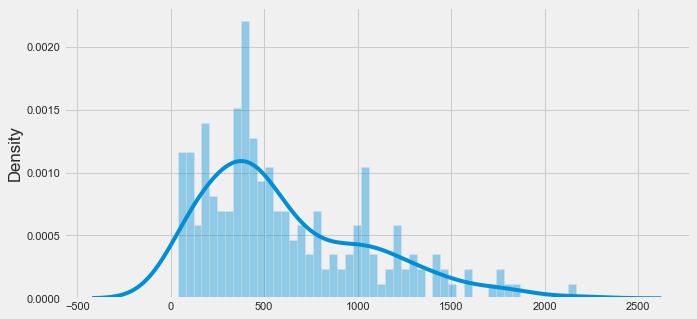

In [40]:
plt.figure(figsize=(10,5))
sns.distplot(proc_statement_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [41]:
split_statement_df = get_split_df(proc_statement_df)
split_statement_df.tail(10)

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
854,statement,2020-07-29,FOMC Statement,Jerome Powell,78,0,0.0,2020-08-27,0,0.0,and businesses over coming months the Federal Reserve will increase its holdings of Treasury securities and agency residential and commercial mortgage backed securities at least at the current pac...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
855,statement,2020-08-27,FOMC Statement,Jerome Powell,200,0,0.0,2020-09-16,0,0.0,Following an extensive review that included numerous public events across the country the Federal Open Market Committee FOMC on Thursday announced the unanimous approval of updates to its Statemen...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
856,statement,2020-08-27,FOMC Statement,Jerome Powell,200,0,0.0,2020-09-16,0,0.0,market can be sustained without causing an unwelcome increase in inflation This first public review of the FOMC framework was announced by Chair Powell in November and involved three distinct comp...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
857,statement,2020-08-27,FOMC Statement,Jerome Powell,87,0,0.0,2020-09-16,0,0.0,communications htm Finally the Committee explored the range of issues that were brought to light during the course of the review in five consecutive meetings beginning in July Analytical staff wor...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
858,statement,2020-09-16,FOMC Statement,Jerome Powell,200,0,0.0,2020-11-05,0,0.0,The COVID pandemic is causing tremendous human and economic hardship across the United States and around the world Economic activity and employment have picked up in recent months but remain well ...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
859,statement,2020-09-16,FOMC Statement,Jerome Powell,200,0,0.0,2020-11-05,0,0.0,these outcomes are achieved The Committee decided to keep the target range for the federal funds rate at to percent and expects it will be appropriate to maintain this target range until labor mar...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Mo

### Filter out by keywords

In [42]:
# Keep sections having keywords and long enough
keyword_statement_df = remove_short_nokeyword(proc_statement_df)
keyword_statement_df.reset_index(drop=True, inplace=True)
print(keyword_statement_df.shape)
keyword_statement_df


(108, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,1,4.25,1994-07-06,0,4.25,"The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sho...","[The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sh...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,1,5.50,1994-12-20,0,5.50,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.","[In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.]","\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op..."
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,-1,5.25,1996-03-26,0,5.25,"For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective im...","[For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective i...",For immediate release\n\n\n\n\n\n\r\n\r\nThe Federal Reserve today announced the following policy \r\nactions:\r\n\r\n\nThe Board of Governors approved a reduction in the discount rate from \r\n5-...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,405,1,5.50,1997-05-20,0,5.50,"For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 pe...","[For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 p...","For immediate release\n\n\n\n\n\n\r\n\r\n\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage poin..."
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,373,-1,5.25,1998-10-15,-1,5.00,"For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1/...","[For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1...","For immediate release\n\n\n\n\n\n\r\nThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage poin..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,statement,2020-04-29,FOMC Statement,Jerome Powell,83,0,0.00,2020-06-10,0,0.00,"The ongoing public health crisis will weigh heavily on economic activity, employment, and inflation in the near term, and poses considerable risks to the economic outlook over the medium term. In ...","[The ongoing public health crisis will weigh heavily on economic activity, employment, and inflation in the near term, and poses considerable risks to the economic outlook over 

In [43]:
# Drop text during the process to reduce the output size
proc_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Minutes DataFrame

In [44]:
minutes_df.head()

,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes


In [45]:
# Reorganize the dataframe
proc_minutes_df = reorganize_df(minutes_df, 'minutes')

No rate decision found:  0
Shape of the dataframe:  (229, 13)


In [46]:
# Check the returned dataframe
proc_minutes_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,10241,0,3.0,1993-02-18,0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,5792,0,3.0,1993-05-18,0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00 ...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,5001,0,3.0,1993-07-07,0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,7064,0,3.0,1993-08-17,0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. a...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. ...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,4679,0,3.0,1993-09-21,0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a.m...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a....","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,9953,-1,0.0,2020-03-19,0,0.0,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal R

In [47]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text


/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

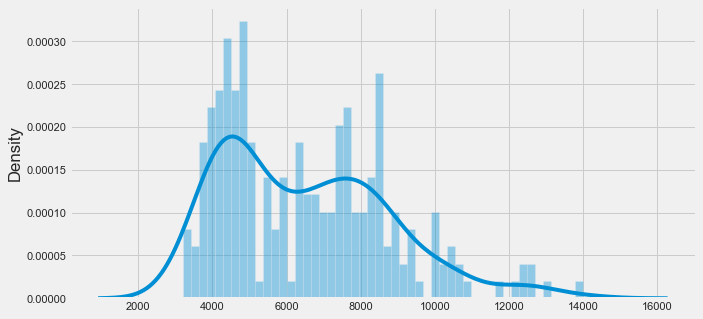

In [48]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [49]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text


Meeting minutes includes various topics, so it makes sense to extract relevant sections. <br />
Check some common sections.

In [50]:
# Check what kind of sections are in common

a = minutes_df.contents.str.lower().str.count('staff economic outlook')
b = minutes_df.contents.str.lower().str.count('developments in financial markets')
c = minutes_df.contents.str.lower().str.count('staff review of the economic situation')
d = minutes_df.contents.str.lower().str.count('staff review of the financial situation')
e = minutes_df.contents.str.lower().str.count('participants\' views on current condition')
f = minutes_df.contents.str.lower().str.count('committee policy action')
g = minutes_df.contents.str.lower().str.count('voting for this action')
h = minutes_df.contents.str.lower().str.count('federal fund')

pd.options.display.max_rows = 300
pd.DataFrame({'date': minutes_df['date'], 'a': a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f, 'g':g, 'h':h})

,date,a,b,c,d,e,f,g,h
0,1993-02-03,0,0,0,0,0,0,0,1
1,1993-03-23,0,0,0,0,0,0,0,3
2,1993-05-18,0,0,0,0,0,0,0,1
3,1993-07-07,0,0,0,0,0,0,0,3
4,1993-08-17,0,0,0,0,0,0,0,1
5,1993-09-21,0,0,0,0,0,0,0,1
6,1993-11-16,0,0,0,0,0,0,0,1
7,1993-12-21,0,0,0,0,0,0,0,2
8,1994-02-04,0,1,0,0,0,0,0,0
9,1994-03-22,0,0,0,0,0,0,0,2


In [51]:
pd.options.display.max_rows = 20

Sections are added from time to time. For example, quarterly economic forcast started in 2009. Leave manually handling those for now, take another approach to filter sentenses by length and key words here.

In [52]:
proc_minutes_df = remove_short_section(proc_minutes_df, min_words=50)

### Split contents to max 200 words

In [53]:
split_minutes_df = get_split_df(proc_minutes_df)
print(split_minutes_df.shape)
split_minutes_df.tail(10)


(8537, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
8527,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,0,0.0,2020-11-05,0,0.0,at the current pace These actions would continue to help sustain smooth market functioning and would continue to help foster accommodative financial conditions thereby supporting the flow of credi...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8528,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,0,0.0,2020-11-05,0,0.0,in part reflecting policy measures to support the economy and the flow of credit to U S households and businesses Members agreed that the Federal Reserve was committed to using its full range of t...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8529,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,0,0.0,2020-11-05,0,0.0,in the new consensus statement in pursuit of the Committee's statutory objectives Accordingly members agreed that the FOMC statement should note that the Committee seeks to achieve maximum employm...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8530,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,0,0.0,2020-11-05,0,0.0,all members agreed on a specification for outcome based forward guidance that indicated that the Committee expects that it will be appropriate to maintain the current setting of the target range f...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8531,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,0,0.0,2020-11-05,0,0.0,a stronger formulation for the forward one in which the Committee would indicate that it expected to maintain the current target range until core inflation had reached percent on a sustained basis...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8532,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,0,0.0,2020-11-05,0,0.0,including readings on public health labor market conditions inflation pressures and inflation expectations and financial and international developments Members noted that the Committee's asset pur...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., F

### Filter out by keywords

In [54]:
# Keep sections having keywords and long enough
keyword_minutes_df = remove_short_nokeyword(proc_minutes_df)
keyword_minutes_df.reset_index(drop=True, inplace=True)
print(keyword_minutes_df.shape)
keyword_minutes_df


(229, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,2119,0,3.0,1993-02-18,0,3.0,"The nominal U.S. merchandise trade deficit widened slightly in November. For October and November together, however, the deficit narrowed a little from its average rate in the third quarte...","[The nominal U.S. merchandise trade deficit widened slightly in November. For October and November together, however, the deficit narrowed a little from its average rate in the third quart...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,1770,0,3.0,1993-05-18,0,3.0,"In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies fell on balance over the intermeeting period. The dollar depreciated through late ...","[In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies fell on balance over the intermeeting period. The dollar depreciated through late...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,1182,0,3.0,1993-07-07,0,3.0,"In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies declined somewhat on balance over the intermeeting period. The dollar depreciated ...","[In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies declined somewhat on balance over the intermeeting period. The dollar depreciated...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,2636,0,3.0,1993-08-17,0,3.0,"Other short-term interest rates also were little changed on balance over the period since the May meeting. Early in the period, unexpectedly robust employment data for May, coupled with me...","[Other short-term interest rates also were little changed on balance over the period since the May meeting. Early in the period, unexpectedly robust employment data for May, coupled with m...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,1272,0,3.0,1993-09-21,0,3.0,"Money market interest rates were little changed on balance over the intermeeting period, while rates on intermediate-term U.S. Treasury obligations and on fixed-rate mortgages dropped slig...","[Money market interest rates were little changed on balance over the intermeeting period, while rates on intermediate-term U.S. Treasury obligations and on fixed-rate mortgages dropped sli...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,2280,-1,0.0,2020-03-19,0,0.0,Developments in Financial Markets and Open Market OperationsThe System Open Market Account (SOMA) manager first reviewed developments in domestic and global financial markets. Financial markets re...,[Developments in Financial Markets and Open Market OperationsThe System Open Market Account (SOMA) manager first reviewed developments in domestic and global financial markets. Financial markets r...,"Th

/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

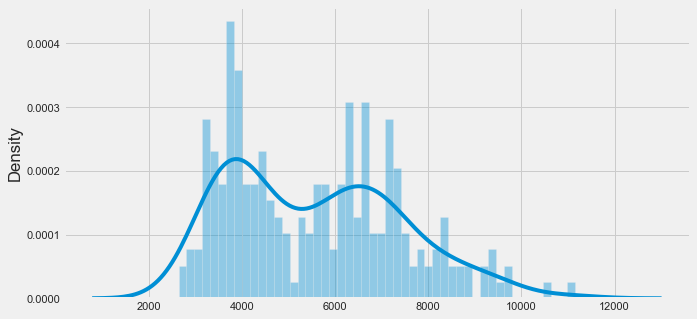

In [55]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [56]:
# Drop text during the process to reduce the output size
proc_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Press Conference Script DataFrame
Press Conference transcripts are available only from 2011

In [57]:
# Sample
print(presconf_script_df['contents'][2])

CHAIRMAN BERNANKE.  Good afternoon, everybody.  Welcome.  In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy.  I will then be glad to take your questions.   As indicated in its statement, the Committee decided today to maintain the policies that were initiated at previous meetings.  In particular, the Committee is keeping the target range for the federal funds rate at 0 to ¼ percent and continues to anticipate that economic conditions are likely to warrant exceptionally low levels for the federal funds rate at least through mid-2013. The Committee will continue the program that we announced in September to extend the average maturity of the Federal Reserve’s holdings of securities by purchasing longer-term Treasury securities and selling an equal amount of shorter-term Treasury securities.  Our purchases of longer-term securities exert downward pressures on longer-term interest rates; at the same time, our guidance about the lik

In [58]:
# Reorganize the dataframe
proc_presconf_script_df = reorganize_df(presconf_script_df, 'presconf_script')


No rate decision found:  0
Shape of the dataframe:  (47, 13)


In [59]:
# Check the returned dataframe
proc_presconf_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,8763,0,0.0,2011-06-22,0,0.0,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,7364,0,0.0,2011-08-01,0,0.0,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...","[CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections...","CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ..."
2,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,7360,0,0.0,2011-11-28,0,0.0,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...","[CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to tak...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take..."
3,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,10135,0,0.0,2012-03-13,0,0.0,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,[CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals ...,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...
4,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,7680,0,0.0,2012-06-20,-1,0.0,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...","[CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in t...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,8212,0,0.0,2020-06-10,0,0.0,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United St...,[CHAIR POWELL. Good afternoon. Thanks

In [60]:
# Check which row does not have rate
proc_presconf_script_df.loc[proc_presconf_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text


### Split by speakers
Scripts contain words from different people, so split by the speaker

In [61]:
script_data_list = []

for i, row in tqdm(proc_presconf_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_presconf_script_df.columns

presconf_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
presconf_script_speaker_df

not matched:  [INAUDIBLE] uncertainty over the outcome of the presidential election could pose a risk to the economic outlook or trigger market turmoil, and has the Fed had any discussions either internally or with the Treasury Department about responding to that, should it happen? 
2020-11-05 00:00:00




,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,1617,0,0.0,2011-06-22,0,0.0,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,64,0,0.0,2011-06-22,0,0.0,"Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarter GDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you see as th...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,198,0,0.0,2011-06-22,0,0.0,"You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2 ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,56,0,0.0,2011-06-22,0,0.0,"Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? And could...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,322,0,0.0,2011-06-22,0,0.0,"Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’ll...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2270,presconf_script,2020-11-05,FOMC Press Conference Transcript,CHAIR POWELL,273,0,0.0,NaT,<NA>,NaN,"You know, so I'm going to take your question literally. And so if the idea is money financed fiscal policy, that's not something that we would consider. So that—what I mean by that is really, yo...","[PRELIMINARY Transcript of Chair Pow

In [62]:
# Filter by the word count
presconf_script_speaker_df = presconf_script_speaker_df.loc[presconf_script_speaker_df['word_count'] >= 50]

(1754, 13)


/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

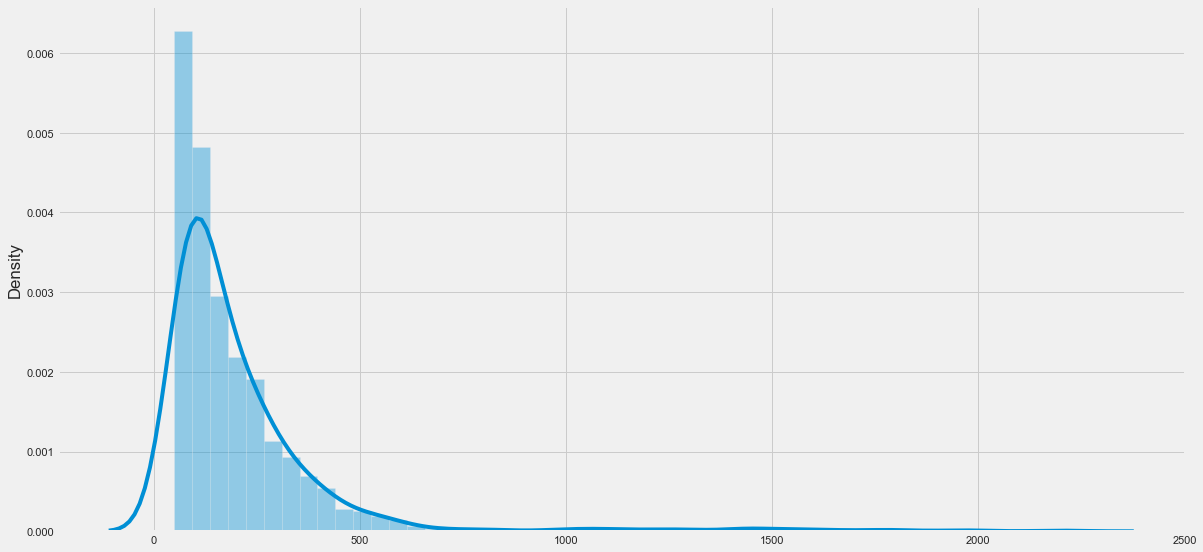

In [63]:
print(presconf_script_speaker_df.shape)
sns.distplot(presconf_script_speaker_df["word_count"].values, bins=50)

In [64]:
# Filter to have only chairperson's speak

tmp_list = []
for i, row in presconf_script_speaker_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = presconf_script_speaker_df.columns
presconf_script_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
presconf_script_chair_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,1617,0,0.0,2011-06-22,0,0.0,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,198,0,0.0,2011-06-22,0,0.0,"You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2 ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,322,0,0.0,2011-06-22,0,0.0,"Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’ll...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,207,0,0.0,2011-06-22,0,0.0,"Thanks, Steve. First, I should start by saying that the Secretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar and Secretary Geithner had some words yesterday. ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,167,0,0.0,2011-06-22,0,0.0,"Well, the dollar—the dollar fluctuates. One factor, for example, that has caused fluctuations that have been quite extreme during the crisis has been the safe-haven effect. So, for example, dur...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,192,0,0.0,NaT,<NA>,NaN,"Thanks. So I'm very reluctant, as you will imagine, to comment on the election directly, indirectly at all other than just to say that it's a good time to take a step back and let the institutio...","[PRELIMINARY Transcript of Chair Powell’s

In [65]:
# Combine scripts of the same speaker for the same day.
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', presconf_script_chair_df.shape)

for i, row in tqdm(presconf_script_chair_df.iterrows()):
    if (row['date'] == tmp_date) and (row['speaker'] == tmp_speaker):
        tmp_data[-1]['text'] += row['text']
        tmp_data[-1]['word_count'] += row['word_count']
        tmp_data[-1]['text_sections'].append(row['text'])
    else:
        tmp_date = row['date']
        tmp_speaker = row['speaker']
        row['text_sections'] = [row['text']]
        tmp_data.append(row)

presconf_script_chair_day_df = pd.DataFrame(tmp_data)

print('After', presconf_script_chair_day_df.shape)
presconf_script_chair_day_df.head()

Before:  (1020, 13)



After (47, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,7504,0,0.0,2011-06-22,0,0.0,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...","[ Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic project...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
21,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,6002,0,0.0,2011-08-01,0,0.0,"Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy stra...","[ Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy str...","CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ..."
40,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,5875,0,0.0,2011-11-28,0,0.0,"Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions. ...","[ Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions. ...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take..."
62,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,7970,0,0.0,2012-03-13,0,0.0,Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. And f...,[ Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. And ...,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...
81,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,5854,0,0.0,2012-06-20,-1,0.0,"Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our ec...","[ Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our e...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th..."


/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

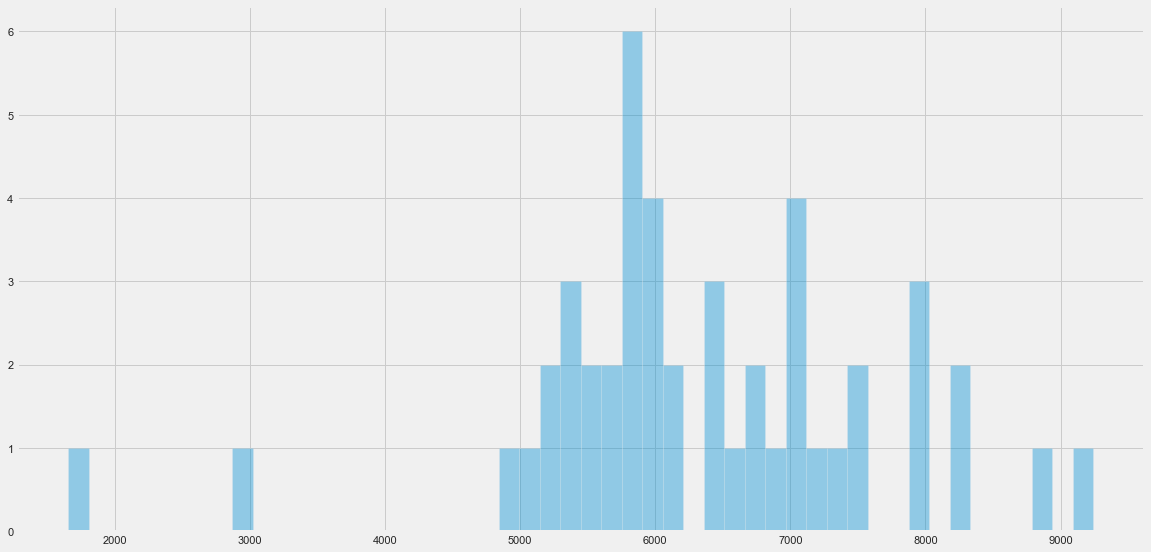

In [66]:
sns.distplot(list(presconf_script_chair_day_df['word_count']), bins=50, kde=False)

In [67]:
# # Check text
# print(presconf_script_chair_day_df['text'][0])

### Split contents to max 200 words

In [68]:
presconf_script_split_df = get_split_df(presconf_script_chair_day_df)
print(presconf_script_split_df.shape)
presconf_script_split_df.tail()


(1990, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
1985,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,200,0,0.0,NaT,<NA>,NaN,fee structure to create incentives for that So we did that We try to be responsive We want you know qualifying businesses to be able to borrow And we ll see how much demand will come You know with...,"[ Good afternoon. At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us—maximum employment and price stability. Since the beginning...","PRELIMINARY Transcript of Chair Powell’s Press Conference \n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed to achieving the monetary policy go..."
1986,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,200,0,0.0,NaT,<NA>,NaN,say we re not out of ammo I m looking at you know a couple of our tools mainly As I mentioned the asset purchase program there's a number of dimensions in which we can adjust that if we deem it to...,"[ Good afternoon. At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us—maximum employment and price stability. Since the beginning...","PRELIMINARY Transcript of Chair Powell’s Press Conference \n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed to achieving the monetary policy go..."
1987,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,200,0,0.0,NaT,<NA>,NaN,and fiscal policy too So it really is if you want to get the economy back as quickly as possible to where we want it to be then really it should be all of government working together Yes There's a...,"[ Good afternoon. At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us—maximum employment and price stability. Since the beginning...","PRELIMINARY Transcript of Chair Powell’s Press Conference \n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed to achieving the monetary policy go..."
1988,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,200,0,0.0,NaT,<NA>,NaN,fairly directly No That's not something we do We have different jobs That know the job of taxation and spending goes to people who have stood for election and been elected and that's the way it sh...,"[ Good afternoon. At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us—maximum employment and price stability. Since the beginning...","PRELIMINARY Transcript of Chair Powell’s Press Conference \n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed to achieving the monetary policy go..."
1989,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,73,0,0.0,NaT,<NA>,NaN,change the you change the you know the nature of the obligation but not the total quantity of debt that the government has when you do these asset purchase programs So I don't know exactly what yo...,"[ Good afternoon. At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us—maximum employment and price stability. Since the beginning...","PRELIMINARY Transcript of Chair Powell’s Press Conference \n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed to achieving the monetary policy go..."


### Filter out by keywords

In [69]:
# Keep sections having keywords and long enough
presconf_script_keyword_df = remove_short_nokeyword(presconf_script_chair_day_df)
presconf_script_keyword_df.reset_index(drop=True, inplace=True)
print(presconf_script_keyword_df.shape)
presconf_script_keyword_df


(47, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,3758,0,0.0,2011-06-22,0,0.0,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projectio...","[ Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic project...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,2322,0,0.0,2011-08-01,0,0.0,"Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy strat...","[ Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy str...","CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ..."
2,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,2432,0,0.0,2011-11-28,0,0.0,"Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions. A...","[ Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions. ...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take..."
3,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,5123,0,0.0,2012-03-13,0,0.0,Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. And fi...,[ Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. And ...,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...
4,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,2179,0,0.0,2012-06-20,-1,0.0,"Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our eco...","[ Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our e...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,2674,0,0.0,2020-06-10,0,0.0,Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United States and around...,[ Good afternoon. Thanks for joi

/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

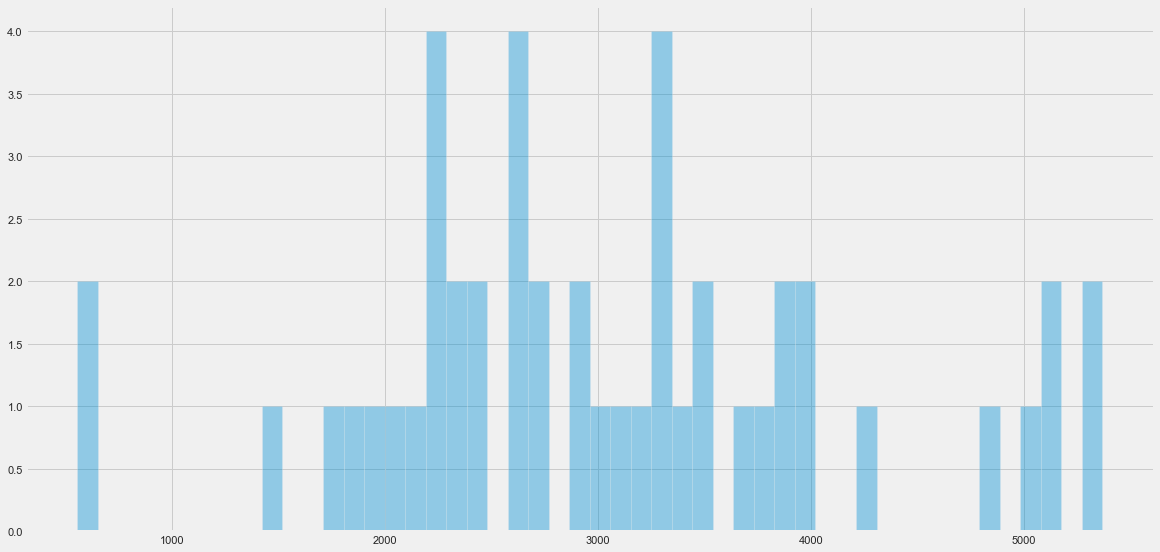

In [70]:
sns.distplot(list(presconf_script_keyword_df['word_count']), bins=50, kde=False)

In [71]:
# Drop text during the process to reduce the output size
presconf_script_chair_day_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Meeting Script DataFrame

In [72]:
# Sample
print(meeting_script_df['contents'][2])

CHAIRMAN GREENSPAN.  Will  someone move  approval  of  theminutes  of  the  March  27th  meeting?

[SECTION]

MS.  SEGER.  I'll move  them.

[SECTION]

MR. KELLEY.  Second.

[SECTION]

CHAIRMAN GREENSPAN.  Without  objection.  Mr.  Cross,  would  youbring us  up  to  date  on  Desk operations?

[SECTION]

MR.  CROSS.  [Statement--see  Appendix.]

[SECTION]

CHAIRMAN GREENSPAN.  Questions  for  Mr.  Cross?  If  there  areno  questions,  would  somebody like  to  move  the  ratification  of  histransactions  since  the  last  meeting?

[SECTION]

VICE  CHAIRMAN  CORRIGAN.  So  moved.

[SECTION]

SPEAKER(?).  Second.

[SECTION]

CHAIRMAN  GREENSPAN.  Without  objection.  Mr.  Sternlight.

[SECTION]

MR.  STERNLIGHT.  Thank you,  Mr.  Chairman.  [Statement--seeAppendix.]

[SECTION]

CHAIRMAN  GREENSPAN.  Are  there  any  questions  for Mr.Sternlight?

[SECTION]

MR.  HOSKINS.  Peter,  in  March  I asked  about  collateral  toback  the  Federal  Reserve  notes.  You thought  there might  be

In [73]:
# Reorganize the dataframe
proc_meeting_script_df = reorganize_df(meeting_script_df, 'meeting_script')


No rate decision found:  0
Shape of the dataframe:  (200, 13)


In [74]:
# Check the returned dataframe
proc_meeting_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1990-02-07,FOMC Meeting Transcript,Alan Greenspan,27040,0,8.25,1990-03-27,0,8.25,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.][SECTION]MESSRS. PRELL & TRUMAN. [Statements--see Appendix.][SECTION]CHAIRMAN GREENSPAN. Questions for the gentlemen?[SECTION]MR. ...,"[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
1,meeting_script,1990-03-27,FOMC Meeting Transcript,Alan Greenspan,39963,0,8.25,1990-04-11,0,8.25,CHAIRMAN GREENSPAN. Governor LaWare has moved that it is agood morning. Are there any seconds?[SECTION]MR. JOHNSON. Second.[SECTION]SPEAKER(?). It's too early to tell![SECTION]CH...,"[CHAIRMAN GREENSPAN. Governor LaWare has moved that it is agood morning. Are there any seconds?, MR. JOHNSON. Second., SPEAKER(?). It's too early to tell!, CHAIRMAN GREENSPAN. C...",CHAIRMAN GREENSPAN. Governor LaWare has moved that it is agood morning. Are there any seconds?\n\n[SECTION]\n\nMR. JOHNSON. Second.\n\n[SECTION]\n\nSPEAKER(?). It's too early to ...
2,meeting_script,1990-05-15,FOMC Meeting Transcript,Alan Greenspan,17304,0,8.25,1990-07-03,0,8.25,CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?[SECTION]MS. SEGER. I'll move them.[SECTION]MR. KELLEY. Second.[SECTION]CHAIRMAN GREENSPAN. Wi...,"[CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?, MS. SEGER. I'll move them., MR. KELLEY. Second., CHAIRMAN GREENSPAN. Without objection. M...",CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move them.\n\n[SECTION]\n\nMR. KELLEY. Second.\n\n[SECTION]\n\...
3,meeting_script,1990-07-03,FOMC Meeting Transcript,Alan Greenspan,26864,0,8.25,1990-08-21,0,8.00,"CHAIRMAN GREENSPAN. Can we get started, please? If somebodywould like to move approval of the minutes--[SECTION]VICE CHAIRMAN CORRIGAN. So move.[SECTION]SPEAKER(?). Second.[SECTION...","[CHAIRMAN GREENSPAN. Can we get started, please? If somebodywould like to move approval of the minutes--, VICE CHAIRMAN CORRIGAN. So move., SPEAKER(?). Second., CHAIRMAN GREENSPAN....","CHAIRMAN GREENSPAN. Can we get started, please? If somebodywould like to move approval of the minutes--\n\n[SECTION]\n\nVICE CHAIRMAN CORRIGAN. So move.\n\n[SECTION]\n\nSPEAKER(?). ..."
4,meeting_script,1990-08-21,FOMC Meeting Transcript,Alan Greenspan,22419,0,8.00,1990-09-07,0,8.00,"CHAIRMAN GREENSPAN. Good morning, everyone. We'll startwith a controversial issue: approval of the minutes.[SECTION]SPEAKER(?). So move.[SECTION]CHAIRMAN GREENSPAN. Is there a se...","[CHAIRMAN GREENSPAN. Good morning, everyone. We'll startwith a controversial issue: approval of the minutes., SPEAKER(?). So move., CHAIRMAN GREENSPAN. Is there a second?, SPEAKE...","CHAIRMAN GREENSPAN. Good morning, everyone. We'll startwith a controversial issue: approval of the minutes.\n\n[SECTION]\n\nSPEAKER(?). So move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,meeting_script,2014-06-18,FOMC Meeting Transcript,Janet Yellen,84860,0,0.00,2014-07-30,0,0.00,"CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: Stan Fischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan and Lael, but b...","[CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: Stan Fischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan and Lael, but ...","CHAIR YELLEN. I’d like to begin by welcoming three people to the tabl

In [75]:
# Check which row does not have rate
proc_meeting_script_df.loc[proc_meeting_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text


(200, 13)


/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

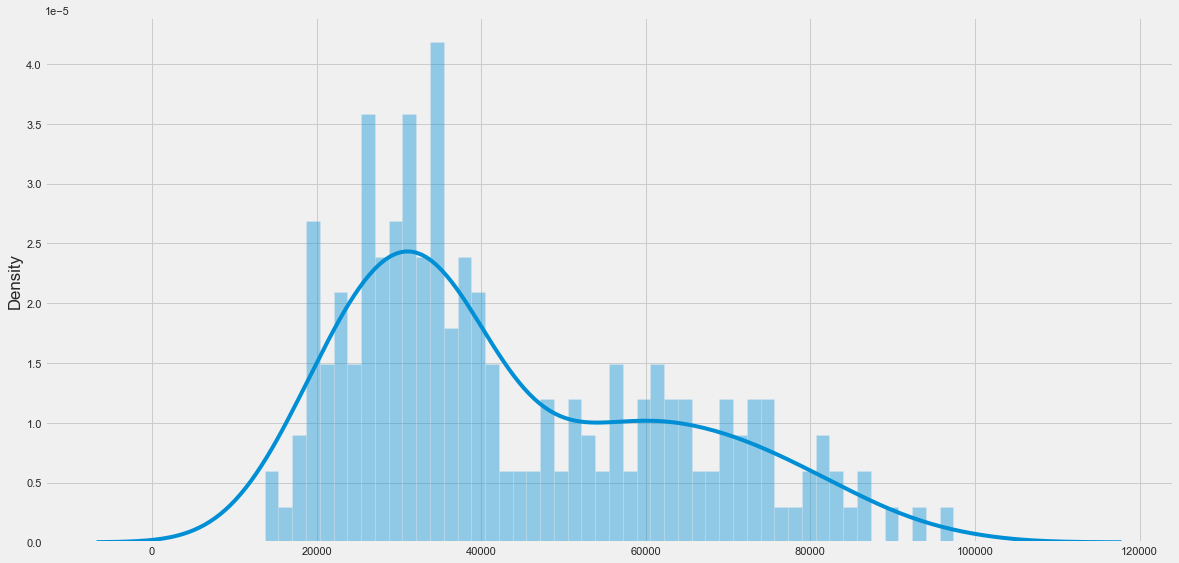

In [76]:
print(proc_meeting_script_df.shape)
sns.distplot(proc_meeting_script_df["word_count"].values, bins=50)

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [77]:
script_data_list = []

for i, row in tqdm(proc_meeting_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_meeting_script_df.columns

meeting_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
meeting_script_speaker_df

not matched:  MR.  [STERN(?)]  We  don't  have  a difference  in  interpretation.
1990-02-07 00:00:00

not matched:  MR. BERNARD.Chairman  Greenspan Vice  Chairman  Corrigan Governor Angell President Boehne President Boykin President Hoskins Governor  Johnson Governor Kelley Governor  LaWare Governor  Seger President  Stern YesYesYesYesYesYesYesYesYesNoYes
1990-02-07 00:00:00

not matched:  SPEAKER(?).  I'm  ready  for  lunch!
1990-02-07 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman Corrigan YesYes2/6-7/90-41-Governor  Angell President  Boehne President  Boykin President Hoskins Governor  Johnson Governor Kelley Governor  LaWare Governor  Seger President  Stern NoYesYesYesYesYesYesNoYes
1990-02-07 00:00:00

not matched:  MR. BERNARD.Chairman  Greenspan Vice  Chairman  Corrigan Governor Angell President Boehne President Boykin President Hoskins Governor  Johnson Governor Kelley Governor  LaWare Governor  Seger President  Stern YesYesYesYesNoNoYesYesYesNoYes
19

not matched:  SPEAKER(?).  Sterilizing!
1991-02-06 00:00:00

not matched:  MR.  BERNARD.Chairman  GreenspanVice  Chairman  CorriganGovernor  AngellPresident  BlackPresident  ForrestalPresident  KeehnGovernor  KelleyGovernor  LaWareGovernor  MullinsPresident  ParryGovernor  SegerYesYesYesYesYesYesYesYesYesYesYes
1991-02-06 00:00:00

not matched:  SPEAKER(?).  Second.
1991-03-26 00:00:00

not matched:  SPEAKER(?).  Why didn't  you  sell  those bonds before  they  lostvalue?
1991-03-26 00:00:00

not matched:  SPEAKERS(?).  Good idea!3/26/91-19-
1991-03-26 00:00:00

not matched:  SPEAKER(?).  So  move.
1991-03-26 00:00:00

not matched:  SPEAKER(?).  Second.
1991-03-26 00:00:00

not matched:  SPEAKER(?).  The  thought  of  coffee  killed  any questions!
1991-03-26 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman  Corrigan Governor  Angell President  Black President  Forrestal President Keehn Governor  Kelley Governor  LaWare Governor  Mullins President  Parry YesYesY

not matched:  MR.  BERNARD.
1992-08-18 00:00:00

not matched:  MR.  MCDONOUGH.
1992-10-06 00:00:00

not matched:  MR. MCDONOUGH.
1992-10-06 00:00:00

not matched:  SPEAKER(?).  Yes,  they  hit  the  100-point  circuit  breaker.
1992-10-06 00:00:00

not matched:  MR.  BERNARDChairman  Greenspan Vice  Chairman  Corrigan Governor  Angell President  Hoenig President  Jordan Governor  Kelley Governor  LaWare Governor  Lindsey President  Melzer Governor Mullins Governor  Phillips President  Syron YesYesYesYesNoYesNoNoNoYesYesYes
1992-10-06 00:00:00

not matched:  SPEAKER(?).  Move it.11/17/92
1992-11-17 00:00:00

not matched:  SPEAKER(?).  That's  right.
1992-11-17 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman  Corrigan Governor  Angell President  Hoenig President  Jordan Governor  Kelley Governor  LaWare Governor  Lindsey President  Melzer Governor  Mullins Governor  Phillips President  Syron YesYesYesYesNoYesNoYesNoYesYesYes
1992-11-17 00:00:00

not matched:  SPE

not matched:  MR. BOEHNE(?).  Move approval.
1994-11-15 00:00:00

not matched:  SPEAKER(?).  Second.
1994-11-15 00:00:00

not matched:  MR. BERNARD:Chairman Greenspan Vice Chairman McDonough Governor Blinder President Broaddus President Forrestal President Jordan Governor Kelley Governor  LaWare Governor  Lindsey President Parry Governor Phillips Governor Yellen ApproveApproveApproveNoApproveApproveApproveApproveApproveApproveApproveApprove
1994-11-15 00:00:00

not matched:  SPEAKER(?).  No  objection.
1994-11-15 00:00:00

not matched:  END OF MEETING
1994-11-15 00:00:00

not matched:  SPEAKER(?).  Second.
1994-12-20 00:00:00

not matched:  SPEAKER(?).  The  flood gate was  it?
1994-12-20 00:00:00

not matched:  SPEAKER(?).  A  less-than-successful building project.
1994-12-20 00:00:00

not matched:  MR. BERNARD.Chairman Greenspan Vice Chairman McDonough Governor Blinder President Broaddus President  Forrestal President Jordan Governor Kelley Governor LaWare Governor Lindsey President 

not matched:  MR. BERNARD.Chairman Greenspan Vice  Chairman McDonough Governor Blinder President  Hoenig Governor Kelley Governor Lindsey President Melzer President Minehan President Moskow Governor  Phillips Governor  Yellen YesYesYesYesYesYesYesYesYesYesYes
1995-12-19 00:00:00

not matched:  END OF MEETING
1995-12-19 00:00:00

not matched:  SPEAKER(?).  Second.
1996-01-31 00:00:00

not matched:  MR. BERNARD.Chairman Greenspan Vice  Chairman McDonough President Boehne President Jordan Governor Kelley Governor Lindsey President McTeer Governor Phillips President  Stern Governor Yellen YesYesYesYesYesYesYesYesYesYes
1996-01-31 00:00:00

not matched:  END OF MEETING
1996-01-31 00:00:00

not matched:  SPEAKER(?).  Move approval.
1996-03-26 00:00:00

not matched:  MR. BERNARD.Chairman Greenspan Vice  Chairman McDonough President Boehne President Jordan Governor  Kelley Governor  Lindsey President McTeer Governor  Phillips President  Stern Governor Yellen YesYesYesYesYesYesYesYesYesYes
1996

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman  McDonough Governor Ferguson Governor Gramlich President Hoenig President Jordan Governor Kelley Governor Meyer President Minehan President Poole Governor Rivlin YesYesYesYesYesNoYesYesYesYesYes
1998-08-18 00:00:00

not matched:  END OF MEETING
1998-08-18 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman  McDonough Governor  Ferguson Governor  Gramlich President Hoenig President Jordan Governor  Kelley Governor  Meyer President Minehan President Poole Governor  Rivlin YesYesYesYesYesYesYesYesYesYesYes
1998-09-29 00:00:00

not matched:  SPEAKER(?).  Let's run  quickly!
1998-09-29 00:00:00

not matched:  END OF MEETING
1998-09-29 00:00:00

not matched:  SPEAKER(?).  Second.
1998-11-17 00:00:00

not matched:  SPEAKER(?).  Second.
1998-11-17 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice Chairman  McDonough Governor Ferguson Governor  Gramlich President Hoenig President Jordan Governor  Kelle

not matched:  END OF MEETING
2005-08-09 00:00:00

not matched:  END OF MEETING
2005-09-20 00:00:00

not matched:  END OF MEETING
2005-11-01 00:00:00

not matched:  END OF MEETING
2005-12-13 00:00:00

not matched:  END OF MEETING
2006-01-31 00:00:00

not matched:  END OF MEETING
2006-03-28 00:00:00

not matched:  END OF MEETING
2006-05-10 00:00:00

not matched:  END OF MEETING
2006-06-29 00:00:00

not matched:  END OF MEETING
2006-09-20 00:00:00

not matched:  END OF MEETING
2006-10-25 00:00:00

not matched:  END OF MEETING
2006-12-12 00:00:00

not matched:  END OF MEETING
2007-01-31 00:00:00

not matched:  END OF MEETING
2007-03-21 00:00:00

not matched:  SPEAKER[?].  Who was this linguist? 
2007-05-09 00:00:00

not matched:  END OF MEETING
2007-05-09 00:00:00

not matched:  END OF MEETING
2007-06-28 00:00:00

not matched:  END OF MEETING
2007-08-07 00:00:00

not matched:  END OF MEETING
2007-09-18 00:00:00

not matched:  END OF MEETING
2007-10-31 00:00:00

not matched:  END OF MEETING

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1990-02-07,FOMC Meeting Transcript,MESSRS. CROSS,4,0,8.25,1990-03-27,0,8.25,& STERNLIGHT. [Statements--see Appendix.],"[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
1,meeting_script,1990-02-07,FOMC Meeting Transcript,MESSRS. PRELL,4,0,8.25,1990-03-27,0,8.25,& TRUMAN. [Statements--see Appendix.],"[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
2,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,4,0,8.25,1990-03-27,0,8.25,Questions for the gentlemen?,"[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
3,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. JOHNSON,92,0,8.25,1990-03-27,0,8.25,"First to Mike: Given the fact that theinflation picture remains stable in spite of slower growth, I waslooking at the profits trend and it's down. There is quite a prof...","[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
4,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. PRELL,299,0,8.25,1990-03-27,0,8.25,"Well, there are a couple of pieces to that andthey are both areas in which researchers have argued a great deal andhave not reached definitive conclusions. One is the in...","[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60524,meeting_script,2014-12-17,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY,1396,0,0.00,2015-01-28,0,0.00,"No worries. It happened one time under Chairman Bernanke’s watch, too. So you can do it once. [Laughter.] I support alternative B, and I am “patient” language. I think “at least the next coup...","[CHAIR YELLEN. Good afternoon, everyone. I think we are ready to begin. The first item we are going to consider is in a joint Board and FOMC meeting, so I need a motion to close the Board meeti...","CHAIR YELLEN. Good afternoon, everyone. I think we are ready to begin. The first item we are going to consider is in a joint Board and FOMC meeting, so I need a motion to close the Board meetin..."
60525,meeting_script,2014-12-17,FOMC Meeting Transcript,CHAIR YELLEN,84,0,0.00,2015-01-28,0,0.00,"Thank you. Okay. I think the main open issue in the statement is the bracketed word “somewhat” in paragraph 1, and I heard one, two, three, four, five, six—eight people propose removing it. I’...","[CHAIR YELL

Some are not matching the defined patterns but those unmatched ones do not look importnant. Thus ignore them here.

In [78]:
# Filter by word count having 20 or more.
print("Before: ", meeting_script_speaker_df.shape)
meeting_script_speaker_df = meeting_script_speaker_df.loc[meeting_script_speaker_df['word_count'] >= 20]
print("After: ", meeting_script_speaker_df.shape)

Before:  (60529, 13)
After:  (30374, 13)


/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

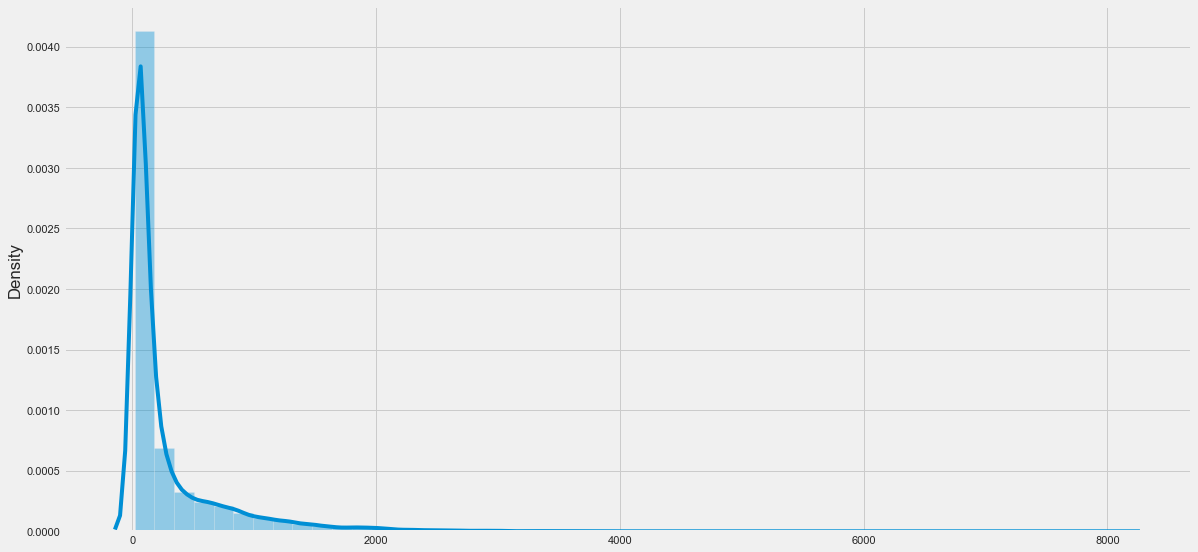

In [79]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

In [80]:
# Combine scripts for the same day.
meeting_script_speaker_df = meeting_script_speaker_df.groupby(['type', 'date', 'title', 'speaker', 'decision', 'rate', 'next_meeting', 'next_decision', 'next_rate'])['text'].apply('[SECTION]'.join).reset_index()
meeting_script_speaker_df['text_sections'] = meeting_script_speaker_df['text'].map(lambda x: x.split("[SECTION]"))
meeting_script_speaker_df['text'] = meeting_script_speaker_df['text'].map(lambda x: x.replace("[SECTION]", ""))
meeting_script_speaker_df['word_count'] = meeting_script_speaker_df['text'].map(get_word_count)
meeting_script_speaker_df


,type,date,title,speaker,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,word_count
0,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abil...,[ There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abi...,903
1,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,"And to the extent that the process mightaccelerate, as indeed it has in the past, we might find that--youknow, it says 1990 to 1994--they might not be full years. They ...","[ And to the extent that the process mightaccelerate, as indeed it has in the past, we might find that--youknow, it says 1990 to 1994--they might not be full years. They ...",1220
2,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. ANGELL,0,8.25,1990-03-27,0,8.25,"You can move to amend, that's right. Mr.Chairman, the reason that I wanted to be earliest is because I reallyhave another suggestion. And if my suggestion gets a second, w...","[ You can move to amend, that's right. Mr.Chairman, the reason that I wanted to be earliest is because I reallyhave another suggestion. And if my suggestion gets a second, ...",163
3,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. ANGELL. My number for real GNP,0,8.25,1990-03-27,0,8.25,"is right underneath thestaff's at 1-1/2 percent real growth, but my nominal number isconsiderably less [than the staff's number]. I put nominal GNP justbarely above 4 percen...","[is right underneath thestaff's at 1-1/2 percent real growth, but my nominal number isconsiderably less [than the staff's number]. I put nominal GNP justbarely above 4 perce...",681
4,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. BERNARD,0,8.25,1990-03-27,0,8.25,"I'm reading from line 59 of the draft directiveor from page 24 in the Bluebook: ""The Federal Open Market Committeeseeks monetary and financial conditions that will foster p...","[ I'm reading from line 59 of the draft directiveor from page 24 in the Bluebook: ""The Federal Open Market Committeeseeks monetary and financial conditions that will foster ...",256
...,...,...,...,...,...,...,...,...,...,...,...,...
6174,meeting_script,2014-12-17,FOMC Meeting Transcript,MS. GEORGE,0,0.00,2015-01-28,0,0.00,"Thank you, Madam Chair. The Tenth District economy has continued to expand at a relatively steady pace, with the exception of energy and agricultural production. Most of our industry contacts n...","[ Thank you, Madam Chair. The Tenth District economy has continued to expand at a relatively steady pace, with the exception of energy and agricultural production. Most of our industry contacts ...",949
6175,meeting_script,2014-12-17,FOMC Meeting Transcript,MS. KLEE,0,0.00,2015-01-28,0,0.00,Thank you. I will be referring to the packet labeled “Material for Briefing on the Summary of Economic Projections.” Exhibit 1 shows the broad trajectories of your forecasts under your individua...,[ Thank you. I will be referring to the packet labeled “Material for Briefing on the Summary of Economic Projections.” Exhibit 1 shows the broad trajectories of your forecasts under your individu...,1140
6176,meeting_script,2014-12-17,FOMC Meeting Transcript,MS. LOGAN,0,0.00,2015-01-28,0,0.00,"Thank you, Madam Chair. I’ll begin again on exhibit 3 with a summary of the recent testing of the term deposit facility and reverse repos, and a staff proposal to continue ON RRP testing in 2015...","[ Thank you, Madam Chair. I’ll begin again on exhibit 3 with a summary of the recent testing of the term deposit facility and reverse repos, and a staff proposal to continue ON RRP testing in 201...",1606
6177,meeting_script,2014-12-17,FOMC Meeting Transcript,MS. MESTER,0,0.00,2015-01-28,0,0.00

/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

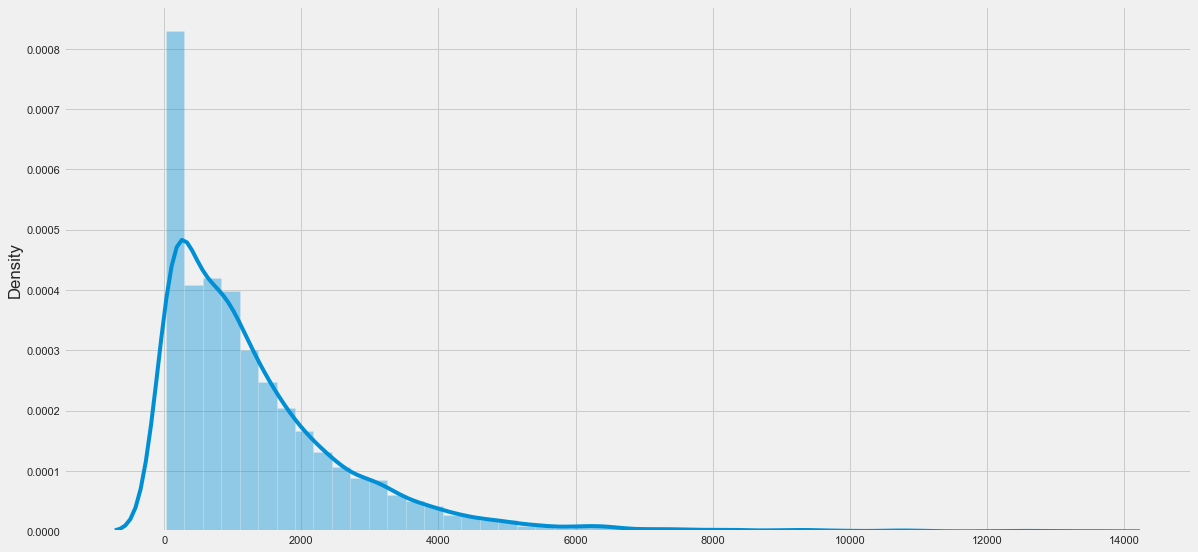

In [81]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [82]:
meeting_script_split_df = get_split_df(meeting_script_speaker_df)
print(meeting_script_split_df.shape)
meeting_script_split_df


(57098, 12)


,type,date,title,speaker,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,word_count
0,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is likely to be a recession And the ability tolock onto an appropriate...,[ There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abi...,200
1,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,up thediscussion to amendments on changes in both and debt So if theSecretary will read I beg your pardon I m sorry Are you okay Alternative II is moved and seconded We re now open to amendments o...,[ There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abi...,200
2,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,of them and I So in effect there is no evidence atthis particular stage that were we to move in that direction we d haveto reverse and move it back up in Sometimes it is easier just to find outqui...,[ There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abi...,200
3,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,the physical aspects of the economy more specifically theincome and product accounts analysis against the balance sheets ofthe financial system If you look strictly at the movement of income consu...,[ There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abi...,200
4,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,of very modest acceleration going on Initial claims whichwill be published tomorrow come down under our seasonals from theirsharp peak of the week before although insured unemployment for theweek ...,[ There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abi...,200
...,...,...,...,...,...,...,...,...,...,...,...,...
57093,meeting_script,2014-12-17,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY,0,0.00,2015-01-28,0,0.00,of monetary policy because all that the first hikes are going to do is to be a very slight removal of a very high level of accommodation So I think we need to monetary policy will still be very su...,"[ I have a question and I have an observation. The question concerns the core PCE forecast on exhibit 4. Since October we’ve seen a stronger dollar, weaker oil prices, and probably a slightly we...",200
57094,meeting_script,2014-12-17,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY,0,0.00,2015-01-28,0,0.00,which has been the situation since we began to end the asset purchase program then we need to move more quickly And I think we need to get market participants sensitized to this that financial mar...,"[ I have a question and I have an observation. The question concerns the core PCE forecast on exhibit 4. Since October we’ve seen a stronger dollar, weaker oil prices, and probably a slightly we...",200
57095,meeting_script,2014-12-17,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY,0,0.00,2015-01-28,0,0.00,that we try to have liftoff occur with as little drama as possible There s already going to be plenty of drama in lifting off with a new set of tools and in a regime shift of raising short term ra...,"[ I have a question and I have an observation. The question concerns the core PCE forecast on exhibit 4. Since October we’ve seen a stronger dollar, weaker o

### Filter out by keywords

In [83]:
# Keep sections having keywords and long enough
meeting_script_keyword_df = remove_short_nokeyword(meeting_script_speaker_df)
meeting_script_keyword_df.reset_index(drop=True, inplace=True)
print(meeting_script_keyword_df.shape)
meeting_script_keyword_df


(4131, 12)


,type,date,title,speaker,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,word_count
0,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,It was one of the things that slippedthrough my in-box and that I read as it was going to my out-box. Thegeneral thrust of the piece--. As I recall it was not contempor...,[ It was one of the things that slippedthrough my in-box and that I read as it was going to my out-box. Thegeneral thrust of the piece--. As I recall it was not contemp...,555
1,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. ANGELL. My number for real GNP,0,8.25,1990-03-27,0,8.25,"is right underneath thestaff's at 1-1/2 percent real growth, but my nominal number isconsiderably less [than the staff's number]. I put nominal GNP justbarely above 4 percen...","[is right underneath thestaff's at 1-1/2 percent real growth, but my nominal number isconsiderably less [than the staff's number]. I put nominal GNP justbarely above 4 perce...",681
2,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. BLACK,0,8.25,1990-03-27,0,8.25,"Mr. Chairman, Governor Johnson's questioningabout these real long-term interest rates prompted me to look at thefootnotes on Chart 15 down in the lower left-hand corner whe...","[ Mr. Chairman, Governor Johnson's questioningabout these real long-term interest rates prompted me to look at thefootnotes on Chart 15 down in the lower left-hand corner w...",59
3,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. FORRESTAL,0,8.25,1990-03-27,0,8.25,"Mr. Chairman, if I may start with theDistrict, I would say that the Sixth District's economy is pretty muchthe same as that of the nation--as good or as bad, depending on ...","[ Mr. Chairman, if I may start with theDistrict, I would say that the Sixth District's economy is pretty muchthe same as that of the nation--as good or as bad, depending o...",680
4,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. GUFFEY,0,8.25,1990-03-27,0,8.25,"Thank you, Mr. Chairman. With regard to theforecast over the upcoming forecast period, for 1990 we're very closeto the Greenbook forecast--a tick stronger in real growth and ver...","[ Thank you, Mr. Chairman. With regard to theforecast over the upcoming forecast period, for 1990 we're very closeto the Greenbook forecast--a tick stronger in real growth and v...",481
...,...,...,...,...,...,...,...,...,...,...,...,...
4126,meeting_script,2014-12-17,FOMC Meeting Transcript,MS. GEORGE,0,0.00,2015-01-28,0,0.00,"Thank you, Madam Chair. The Tenth District economy has continued to expand at a relatively steady pace, with the exception of energy and agricultural production. Most of our industry contacts no...","[ Thank you, Madam Chair. The Tenth District economy has continued to expand at a relatively steady pace, with the exception of energy and agricultural production. Most of our industry contacts ...",727
4127,meeting_script,2014-12-17,FOMC Meeting Transcript,MS. KLEE,0,0.00,2015-01-28,0,0.00,Thank you. I will be referring to the packet labeled “Material for Briefing on the Summary of Economic Projections.” Exhibit 1 shows the broad trajectories of your forecasts under your individual...,[ Thank you. I will be referring to the packet labeled “Material for Briefing on the Summary of Economic Projections.” Exhibit 1 shows the broad trajectories of your forecasts under your individu...,1140
4128,meeting_script,2014-12-17,FOMC Meeting Transcript,MS. LOGAN,0,0.00,2015-01-28,0,0.00,"Thank you, Madam Chair. I’ll begin again on exhibit 3 with a summary of the recent testing of the term deposit facility and reverse repos, and a staff proposal to continue ON RRP testing in 2015....","[ Thank you, Madam Chair. I’ll begin again on exhibit 3 with a summary of the recent testing of the term deposit facility and reverse repos, and a staff proposal to continue ON RRP testing in 201...",1513
4129,meeting_script,2014-12-17,FOMC Meeting Transcript,MS. MESTER,0,0.00,2015-01-28,0,0

In [84]:
# Drop text during the process to reduce the output size
meeting_script_speaker_df.drop(columns=['text_sections'], inplace=True)
meeting_script_split_df.drop(columns=['text_sections'], inplace=True)
meeting_script_keyword_df.drop(columns=['text_sections'], inplace=True)

## Speech DataFrame

In [85]:
# Reorganize the dataframe
proc_speech_df = reorganize_df(speech_df, 'speech')

No rate decision found:  1487
Shape of the dataframe:  (1487, 13)


In [86]:
# Check the returned dataframe
# Note that rate and decision are not applicable because speech is not at FOMC meeting
proc_speech_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,3211,<NA>,None,1996-07-03,0,5.25,"Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996[SECTION][SECTION]I am honored to present...","[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",2694,<NA>,None,1996-07-03,0,5.25,"Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here th...","[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon ...","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i..."
2,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,2902,<NA>,None,1996-09-24,0,5.25,Monetary Policy Objectives and Strategy[SECTION]I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want ...,"[Monetary Policy Objectives and Strategy, I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emp...",Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...
3,speech,1996-09-19,Regulation and electronic payment systems,Chairman Alan Greenspan,1988,<NA>,None,1996-09-24,0,5.25,"Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996[SE...","[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
4,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,2180,<NA>,None,1996-11-13,0,5.25,"Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996[SECTION][SECTION]Small Business Is Big Business[SECTION]It is my pleasure to ...","[Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996, , Small Business Is Big Business, It is my pleasure to be here today at the...","Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,speech,2020-10-15,Modernizing and Strengthening CRA Regulations: A Conversation with Minority Depository Institutions,Governor Lael Brainard,2271,<NA>,None,2020-11-05,0,0.00,"The Federal Reserve, the centr

(1487, 13)


/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

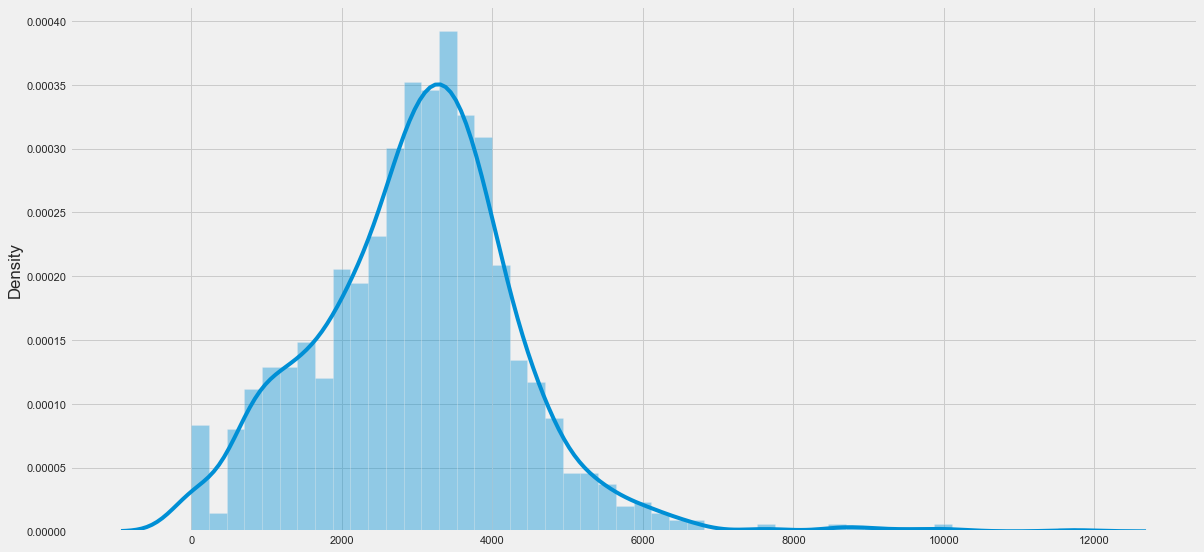

In [87]:
print(proc_speech_df.shape)
sns.distplot(proc_speech_df["word_count"].values, bins=50)

In [88]:
# Check records where speaker is null
proc_speech_df['speaker'].isnull().sum()

0

In [89]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_speech_df = remove_short_section(proc_speech_df, min_words=50)
proc_speech_df


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,3095,<NA>,None,1996-07-03,0,5.25,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world. I am especially delighted to have with us B...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",2659,<NA>,None,1996-07-03,0,5.25,"It is a pleasure to be here this afternoon to provide the Federal Reserve's perspective on recent developments in the field of electronic money and banking. To begin, let me remind yo...","[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon ...","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i..."
2,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,2729,<NA>,None,1996-09-24,0,5.25,I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emphasize the importance of setting monetary ...,"[Monetary Policy Objectives and Strategy, I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emp...",Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...
3,speech,1996-09-19,Regulation and electronic payment systems,Chairman Alan Greenspan,1586,<NA>,None,1996-09-24,0,5.25,You have heard many points of view today on electronic moneyand banking. New products are being designed to challenge theuse of currency and checks in millions of routine consumertransactions. O...,"[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
4,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,2002,<NA>,None,1996-11-13,0,5.25,"A fair question might be, what is the nation's central bank doing sponsoring aconference on small business? Well, let me be clear about one thing, neither I nor mycolleagues from the Fed are goi...","[Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996, , Small Business Is Big Business, It is my pleasure to be here today at the...","Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,speech,2020-10-15,Modernizing and Strengthening CRA Regulations: A Conversation with Minority Depository Institutions,Governor Lael Brainard,2090,<NA>,None,2020-11-05,0,0.00,"As mission-driven financial institutions with a focus on serving

In [90]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_speech_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_speech_df.columns
speech_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)

print(speech_chair_df.shape)
speech_chair_df

(430, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,3095,<NA>,None,1996-07-03,0,5.25,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world. I am especially delighted to have with us B...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-09-19,Regulation and electronic payment systems,Alan Greenspan,1586,<NA>,None,1996-09-24,0,5.25,You have heard many points of view today on electronic moneyand banking. New products are being designed to challenge theuse of currency and checks in millions of routine consumertransactions. O...,"[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
2,speech,1996-10-05,"Bank supervision, regulation, and risk",Alan Greenspan,2183,<NA>,None,1996-11-13,0,5.25,You may well wonder why a regulator is the first speaker at a conference in which amajor theme is maximizing shareholder value. I hope that by the end of my remarks thismorning it will be clear t...,"[Remarks by Chairman Alan GreenspanBank supervision, regulation, and riskAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii October 5, 1996, , You may well wonder why a...","Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\..."
3,speech,1996-10-07,U.S. Treasury securities market: Lessons from Alexander Hamilton,Alan Greenspan,985,<NA>,None,1996-11-13,0,5.25,I thank the members of the Public Securities Association for bestowing upon me this award for distinguished public service. I am particularly honored by the company that I keep as a winner of thi...,"[Remarks by Chairman Alan GreenspanU.S. Treasury securities market: Lessons from Alexander HamiltonAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, New Yo...","Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N..."
4,speech,1996-10-16,Technological advances and productivity,Alan Greenspan,1615,<NA>,None,1996-11-13,0,5.25,The Conference Board has been an important institution in my life. It was where I started as an economist. It was where I came into contact with a business world I had never known before. The y...,"[Remarks by Chairman Alan GreenspanTechnological advances and productivityAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New YorkOctober 16, 1996, , It is a pleasure to b...","Remarks by Chairman Alan Greenspan\nTechnological advances and productivity\r\nAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New York\r\nOctober 16, 1996\n\n[SECTION]\n\..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,speech,2020-05-13,Current Economic Issues,Jerome Powell,1206,<NA>,None,2020-06-10,0,0.00,"The coronavirus has left a devastating human and economic toll in its wake as it has spread around the globe. This is a worldwide public health crisis, and health-care work

### Split contents to max 200 words

In [91]:
speech_split_df = get_split_df(speech_chair_df)
speech_split_df.reset_index(drop=True, inplace=True)
print(speech_split_df.shape)
speech_split_df


(7086, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world I am especially delighted to have with us Bill's wife Sha...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,best from himself and from those around him He understood that a safe and sound banking system was essential to a healthy market system and he was committed to maintaining such a system His contri...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
2,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,reflect the increased efficiency of financial markets worldwide which have helped to bring about expanded international trade and economic growth However by strengthening the interdependencies amo...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
3,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,relationship we may have a better framework for considering how to supervise and regulate our financial institutions A Leveraged Banking System In addressing these issues it is important to rememb...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
4,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,of intermediation with the founding of the Riksbank more than years ago as a private institution Of course this same leverage and risk taking also greatly increases the possibility of bank failure...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7081,speech,2020-10-06,Recent Economic Developments and the Challenges Ahead,Jerome Powell,200,<NA>,None,2020-11-05,0,0.00,controlling the spread and effects of the virus There is a risk that the rapid initial gains from reopening may transition to a longer than expected slog back to full reco

### Filter out by keyword

In [92]:
# Keep sections having keywords and long enough
speech_keyword_df = remove_short_nokeyword(speech_chair_df)
speech_keyword_df.reset_index(drop=True, inplace=True)
print(speech_keyword_df.shape)
speech_keyword_df


(221, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-10-05,"Bank supervision, regulation, and risk",Alan Greenspan,136,<NA>,None,1996-11-13,0,5.25,"While awaiting perfection, it is useful to underline that regulators and banks have acommon interest in using the evolving new technologies to meet their own separateobjectives: maximizing shareh...","[While awaiting perfection, it is useful to underline that regulators and banks have acommon interest in using the evolving new technologies to meet their own separateobjectives: maximizing share...","Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\..."
1,speech,1996-12-06,Social security,Alan Greenspan,253,<NA>,None,1996-12-17,0,5.25,"While such evaluations are based on an uncertain future, the benefit per current retiree under existing law, adjusted for inflation, can be forecast with some precision over the next thirty years....","[While such evaluations are based on an uncertain future, the benefit per current retiree under existing law, adjusted for inflation, can be forecast with some precision over the next thirty years...","\n\n[SECTION]\n\nI am privileged to accept the Union League of Philadelphia's Abraham Lincoln award. This is the first time I have been at the Union League in nearly four decades, but I am gratif..."
2,speech,1997-01-14,Central banking and global finance,Alan Greenspan,133,<NA>,None,1997-02-05,0,5.25,"In theory, the allocation of responsibility for risk-bearing between the private sectorand the central bank depends upon an evaluation of the private cost of capital. In order toattract, or at le...","[In theory, the allocation of responsibility for risk-bearing between the private sectorand the central bank depends upon an evaluation of the private cost of capital. In order toattract, or at l...","\n\n[SECTION]\n\nCentral Banking and Global Finance\n\n[SECTION]\n\nMr. Prime Minister, Minister of Finance, Minister of Budget, Rector Oosterlinck,\r\nProfessor Peeters, ladies and gentlemen, it ..."
3,speech,1997-02-21,Government regulation and derivative contracts,Alan Greenspan,212,<NA>,None,1997-03-25,1,5.50,"In the case of the institutional off-exchange derivatives markets, it seems abundantly clear that private market regulation is quite effectively and efficiently achieving what have been identified...","[In the case of the institutional off-exchange derivatives markets, it seems abundantly clear that private market regulation is quite effectively and efficiently achieving what have been identifie...","I am pleased to participate once again in the Federal Reserve Bank of Atlanta's annual Financial Markets Conference. As in previous years, the Reserve Bank has developed a conference program that..."
4,speech,1997-04-29,G-7 economic summit meeting,Alan Greenspan,142,<NA>,None,1997-05-20,0,5.50,"In theory, the allocation of responsibility for risk-bearing between the private sector and the central bank depends upon an evaluation of the private cost of capital. In order to attract, or at ...","[In theory, the allocation of responsibility for risk-bearing between the private sector and the central bank depends upon an evaluation of the private cost of capital. In order to attract, or at...","\n\n[SECTION]\n\nIt is a pleasure to be here today.\n\n[SECTION]\n\nI will take this occasion to offer some thoughts related to the upcoming G-7 economic summit meeting, which will be held in Denv..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,speech,2019-10-09,Opening Remarks,Jerome Powell,150,<NA>,None,2019-10-30,-1,1.50,"Now is a good time to conduct the review. Unemployment is at a half-century low, and inflation is running close to, but a bit below, our 2 percent objective. While not everyone fully shares econom...","[Now is a good ti

In [93]:
# Drop text_sections
speech_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Testimony DataFrame

In [94]:
# Reorganize the dataframe
# Note that rate and decision are not applicable because testimony is not at FOMC meeting
proc_testimony_df = reorganize_df(testimony_df, 'testimony')

No rate decision found:  441
Shape of the dataframe:  (441, 13)


In [95]:
# Check the returned dataframe
proc_testimony_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",2298,<NA>,None,1996-07-03,0,5.25,[SECTION][SECTION][SECTION][SECTION]It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent pub...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
1,testimony,1996-07-17,"""Prime bank"" schemes","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation",1227,<NA>,None,1996-08-20,0,5.25,"[SECTION][SECTION][SECTION][SECTION]I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past s...","[, , , , I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the...","\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Chairman Alan Greenspan,3372,<NA>,None,1996-08-20,0,5.25,"Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996[SECTION]Before I t...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-24,Trends in consumer lending,Governor Janet L. Yellen,2878,<NA>,None,1996-08-20,0,5.25,[SECTION][SECTION][SECTION][SECTION]I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in thi...,"[, , , , I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S....",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...
4,testimony,1996-07-26,Recent reports on Federal Reserve operations,Chairman Alan Greenspan,3764,<NA>,None,1996-08-20,0,5.25,[SECTION][SECTION][SECTION][SECTION]I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevan...,"[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,testimony,2020-06-16,Semiannual Monetary Policy Report to the Congress,Chair Jerome H. Powell,1701,<NA>,None,2020-07-29,0,0.00,"The Federal Reserve, the central bank of the United States, p

(441, 13)


/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

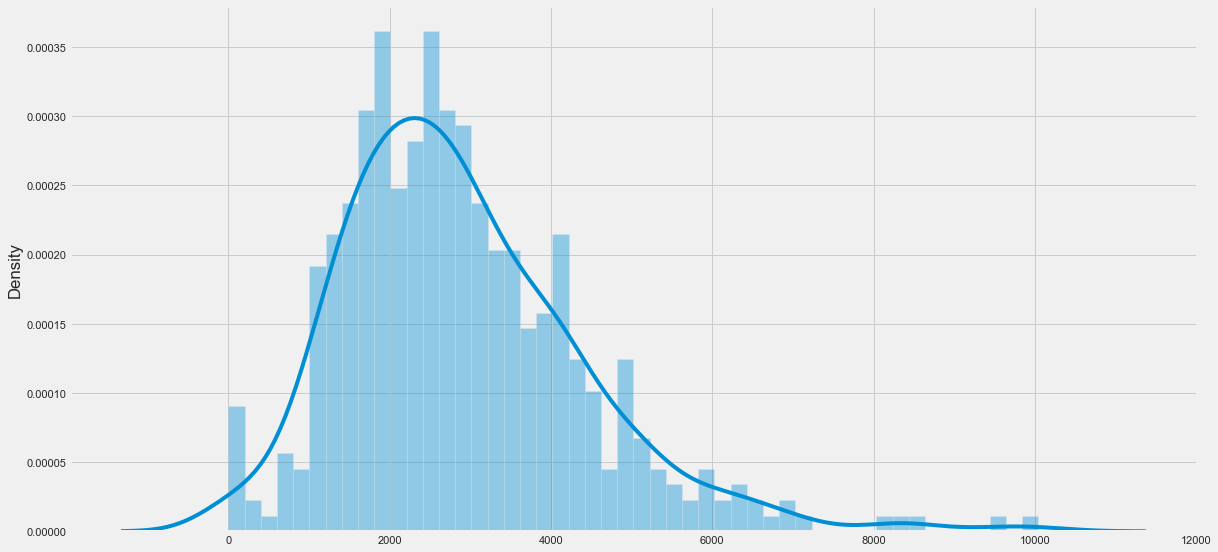

In [96]:
print(proc_testimony_df.shape)
sns.distplot(proc_testimony_df["word_count"].values, bins=50)

In [97]:
# Check records where speaker is null
proc_testimony_df['speaker'].isnull().sum()

0

In [98]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_testimony_df = remove_short_section(proc_testimony_df, min_words=50)
proc_testimony_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",2071,<NA>,None,1996-07-03,0,5.25,It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey results h...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
1,testimony,1996-07-17,"""Prime bank"" schemes","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation",959,<NA>,None,1996-08-20,0,5.25,"I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the problem ...","[, , , , I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the...","\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Chairman Alan Greenspan,2966,<NA>,None,1996-08-20,0,5.25,"Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-24,Trends in consumer lending,Governor Janet L. Yellen,2601,<NA>,None,1996-08-20,0,5.25,I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S. commerci...,"[, , , , I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S....",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...
4,testimony,1996-07-26,Recent reports on Federal Reserve operations,Chairman Alan Greenspan,3308,<NA>,None,1996-08-20,0,5.25,"We are strongly committed to ensuring that the Federal Reserve Systemis managed efficiently and effectively. It is most important to us at the FederalReserve Board and the Reserve Banks, not only...","[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,testimony,2020-06-16,Semiannual Monetary Policy Report to the Congress,Chair Jerome H. Powell,1433,<NA>,None,2020-07-29,0,0.00,"Our country continues to face a difficult and challenging ti

In [99]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_testimony_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_testimony_df.columns
testimony_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
testimony_chair_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,2966,<NA>,None,1996-08-20,0,5.25,"Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1996-07-26,Recent reports on Federal Reserve operations,Alan Greenspan,3308,<NA>,None,1996-08-20,0,5.25,"We are strongly committed to ensuring that the Federal Reserve Systemis managed efficiently and effectively. It is most important to us at the FederalReserve Board and the Reserve Banks, not only...","[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
2,testimony,1997-01-21,"January 21, 1997",Alan Greenspan,2854,<NA>,None,1997-02-05,0,5.25,"Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","[Testimony of Chairman Alan GreenspanPerformance of the U.S. economyBefore the Committee on the Budget, United States SenateJanuary 21, 1997, Mr. Chairman and members of the Committee, I am please...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th..."
3,testimony,1997-01-30,The comsumer price index,Alan Greenspan,2692,<NA>,None,1997-02-05,0,5.25,"Mr. Chairman and members of the Committee, I appreciate the opportunity to appear before you today. The Committee is faced with a number of complex policy issues that will have an important beari...","[Testimony of Chairman Alan GreenspanThe consumer price indexBefore the Committee on Finance, United States SenateJanuary 30, 1997, Mr. Chairman and members of the Committee, I appreciate the oppo...","Testimony of Chairman Alan Greenspan\nThe consumer price index\r\nBefore the Committee on Finance, United States Senate\r\nJanuary 30, 1997\n\n[SECTION]\n\nMr. Chairman and members of the Committe..."
4,testimony,1997-02-13,Modernization of the financial system,Alan Greenspan,4100,<NA>,None,1997-03-25,1,5.50,"Madam Chairwoman, members of the Subcommittee on Financial Institutions and Consumer Credit, it is a pleasure to appear here today to present the views of the Federal Reserve Board on some broad i...","[Testimony of Chairman Alan GreenspanModernization of the financial systemBefore the Subcommittee on Financial Institutions and Consumer Credit\tof the Committee on Banking and Financial Services,...",Testimony of Chairman Alan Greenspan\nModernization of the financial system\r\nBefore the Subcommittee on Financial Institutions and Consumer Credit\r\n\tof the Committee on Banking and Financial ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,testimony,2020-02-11,Semiannual Monetary Policy Report to the Congress,Jerome Powell,1171,<NA>,None,2020-03-03,-1,1.00,My colleagues and I strongly support the goals of maximum employment and price stability that Congress has set for monetary policy. Congress has given us 

### Split contents to max 200 words

In [100]:
testimony_split_df = get_split_df(testimony_chair_df)
testimony_split_df.reset_index(drop=True, inplace=True)
print(testimony_split_df.shape)
testimony_split_df


(2834, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,0,5.25,Before I take this opportunity to discuss the performance of the U S economy and the conduct of monetary policy I would first like to thank theChairman and the other members of this Committee for ...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,0,5.25,above their postwar averages About million workers have beenadded to nonfarm payrolls in the first six months of the year and theunemployment rate fell to percent in June Even though the U S econo...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,0,5.25,be better than manyanalysts expected An important supporting factor as I pointed out in February wasfavorable conditions in financial markets in the latter part of and early Intermediate and longe...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,0,5.25,better than those of many ofour major trading partners The rise in the dollar helps to keep down pricepressures but it also tends to divert domestic demand toward imported goods anddamp exports so...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
4,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,0,5.25,less rapidly asfinal demand slows some While these are all good reasons to anticipate that economic growth willmoderate some the timing and extent of that downshift are uncertain We havenot as yet...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,testimony,2020-09-22,"Coronavirus Aid, Relief, and Economic Security Act",Jerome Powell,200,<NA>,None,2020-11-05,0,0.00,U S companies so that they can maintain business operations and capacity during the perio

### Filter out by keyword

In [101]:
# Keep sections having keywords and long enough
testimony_keyword_df = remove_short_nokeyword(testimony_chair_df)
testimony_keyword_df.reset_index(drop=True, inplace=True)
print(testimony_keyword_df.shape)
testimony_keyword_df


(124, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,628,<NA>,None,1996-08-20,0,5.25,"Even though the U.S. economy is using its productive resources intensively,inflation has remained quiescent. The core inflation rate, measured by the consumerprice index less food and energy pric...","[Even though the U.S. economy is using its productive resources intensively,inflation has remained quiescent. The core inflation rate, measured by the consumerprice index less food and energy pri...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1997-01-21,"January 21, 1997",Alan Greenspan,549,<NA>,None,1997-02-05,0,5.25,"Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","[Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th..."
2,testimony,1997-02-26,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,286,<NA>,None,1997-03-25,1,5.50,"The performance of the U.S. economy over the past year has been quite favorable. Real GDP growth picked up to more than three percent over the four quarters of 1996, as the economy progr...","[The performance of the U.S. economy over the past year has been quite favorable. Real GDP growth picked up to more than three percent over the four quarters of 1996, as the economy prog...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nFebruary 26, 1997\n\n[..."
3,testimony,1997-03-20,Performance of the U.S. economy,Alan Greenspan,160,<NA>,None,1997-03-25,1,5.50,"Indeed, the labor markets bear especially careful watching for signs that such a process is under way. So far this year, the demand for labor has stayed strong. Payroll employment grew briskly i...","[Indeed, the labor markets bear especially careful watching for signs that such a process is under way. So far this year, the demand for labor has stayed strong. Payroll employment grew briskly ...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nJoint Economic Committee, United States Congress\r\n\r\nMarch 20, 1997\n\n[SECTION]\n\n\n\n[SECTION]\n\nMr. Chairman and me..."
4,testimony,1997-07-22,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,1068,<NA>,None,1997-08-19,0,5.50,This strong expansion has produced a remarkable increase in work opportunities for Americans. A net of more than thirteen million jobs has been created since the ...,[This strong expansion has produced a remarkable increase in work opportunities for Americans. A net of more than thirteen million jobs has been created since the ...,"Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 22, 1997\n\n[SECT..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,testimony,2019-11-13,The Economic Outlook,Jerome Powell,776,<NA>,None,2019-12-11,0,1.50,"Chairman Lee, Vice Chair Maloney, and members of the Committee, I appreciate the opportunity to testify before you today. Let me start by saying that my colleagues and I strongly support the goals...","[Chairman Lee, Vice Chair Maloney, and me

In [102]:
# Drop text sections
testimony_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Save the train data

In [103]:
# Combine dataframes
text_no_split = pd.concat([proc_statement_df, 
                           proc_minutes_df, 
                           presconf_script_chair_day_df, 
                           meeting_script_speaker_df, 
                           speech_chair_df,
                           testimony_chair_df], sort=False)
text_no_split.reset_index(drop=True, inplace=True)

text_split_200 = pd.concat([split_statement_df, 
                            split_minutes_df, 
                            presconf_script_split_df, 
                            meeting_script_split_df, 
                            speech_split_df, 
                            testimony_split_df], sort=False)
text_split_200.reset_index(drop=True, inplace=True)

text_keyword = pd.concat([keyword_statement_df,
                          keyword_minutes_df,
                          presconf_script_keyword_df,
                          meeting_script_keyword_df, 
                          speech_keyword_df, 
                          testimony_keyword_df], sort=False)
text_keyword.reset_index(drop=True, inplace=True)

In [104]:
def save_data(df, file_name, dir_name='../data/preprocessed/'):
    '''
    Save the given df to pickle file and csv file in the given directory.
    '''
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print("Data Saved to a pickle file in {} !".format(dir_name))

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print("Data Saved to a csv file in {} !".format(dir_name))
    

In [105]:
save_data(text_no_split, 'text_no_split')
save_data(text_split_200, 'text_split_200')
save_data(text_keyword, 'text_keyword')

Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
